<p style="font-size:11px;"><em><strong>Créditos</strong>: El contenido de este cuaderno ha sido tomado de varias fuentes, <a href="https://medium.com/analytics-vidhya/the-beginners-guide-to-choropleth-maps-in-python-ff1da28a8943">Muntasir Wahed</a>, <a href="https://anderfernandez.com/en/blog/kmeans-algorithm-python/?utm_source=en&utm_medium=email">Ander Fernández Jauregui</a>, pero especialmente de los cursos y libros publicados abierta y libremente por <a href="http://darribas.org/">Dani Arribas-Bel</a> - University of Liverpool & <a href="http://spatial.ucr.edu/peopleRey.html">Sergio Rey</a> - Center for Geospatial Sciences, University of California, Riverside. El compilador se disculpa por cualquier omisión involuntaria y estaría encantado de agregar un reconocimiento.</em></p>

# Cluster espacial

Esta sesión cubre el agrupamiento (*cluster*) estadístico de observaciones espaciales. Muchas preguntas y temas son fenómenos complejos que involucran varias dimensiones y son difíciles de resumir en una sola variable. En términos estadísticos, llamamos a esta familia de problemas *multivariados*, en oposición a los casos *univariados* donde solo se considera una sola variable en el análisis. El agrupamiento aborda este tipo de preguntas reduciendo su dimensionalidad, es decir, el número de variables relevantes que el analista necesita analizar, y convirtiéndolo en un conjunto más intuitivo de clases que incluso audiencias no técnicas pueden entender y comprender. Por esta razón, se utiliza ampliamente en contextos aplicados como la toma de decisiones políticas o el marketing. Además, dado que estos métodos no requieren muchas suposiciones preliminares sobre la estructura de los datos, es una herramienta exploratoria comúnmente utilizada, ya que puede dar rápidamente pistas sobre la forma, la estructura y el contenido de un conjunto de datos.

La idea básica del agrupamiento estadístico es resumir la información contenida en varias variables creando un número relativamente pequeño de categorías. Luego, cada observación en el conjunto de datos se asigna a una, y solo una, categoría según sus valores para las variables consideradas originalmente en la clasificación. Si se hace correctamente, el ejercicio reduce la complejidad de un problema multidimensional mientras conserva toda la información significativa contenida en el conjunto de datos original. Esto se debe a que, una vez clasificado, el analista solo necesita verificar en qué categoría cae cada observación, en lugar de considerar los múltiples valores asociados con cada una de las variables y tratar de descifrar cómo combinarlos de manera coherente.

Aunque existen muchas técnicas para agrupar estadísticamente observaciones en un conjunto de datos, todas se basan en la premisa de utilizar un conjunto de atributos para definir clases o categorías de observaciones que son similares *dentro* de cada una de ellas, pero difieren *entre* grupos. Cómo se define la similitud dentro de los grupos y la disimilitud entre ellos y cómo se opera el algoritmo de clasificación es lo que hace que las técnicas difieran y también lo que hace que cada una de ellas sea especialmente adecuada para problemas específicos o tipos de datos. Como ilustración, solo nos sumergiremos en uno de estos métodos, *K-means,* que es probablemente la técnica más comúnmente utilizada para el agrupamiento estadístico.

Pero antes de proceder a una agrapacion espacial, realicemos inicialmente un agrupamiento que no considera la espacialidad como por ejemplo el método **K-means**

In [1]:
from esda.moran import Moran
import numpy as np
import libpysal.weights.set_operations as Wsets
from libpysal.weights import Queen, KNN
import seaborn as sns
from pysal.lib import weights
import geopandas as gpd
import contextily as cx
from sklearn import cluster
from sklearn.cluster import KMeans, AgglomerativeClustering

In [2]:
# Read the file in
abb = gpd.read_file("https://darribas.org/gds_course/content/data/london_abb.gpkg")

# Inspect the structure of the table
abb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   MSOA_CODE                    353 non-null    object  
 1   accommodates                 353 non-null    float64 
 2   bathrooms                    353 non-null    float64 
 3   bedrooms                     353 non-null    float64 
 4   beds                         353 non-null    float64 
 5   number_of_reviews            353 non-null    float64 
 6   reviews_per_month            353 non-null    float64 
 7   review_scores_rating         353 non-null    float64 
 8   review_scores_accuracy       353 non-null    float64 
 9   review_scores_cleanliness    353 non-null    float64 
 10  review_scores_checkin        353 non-null    float64 
 11  review_scores_communication  353 non-null    float64 
 12  review_scores_location       353 non-null    float64 
 1

In [3]:
variables=["bathrooms", "bedrooms", "beds", "number_of_reviews"]

<Axes: >

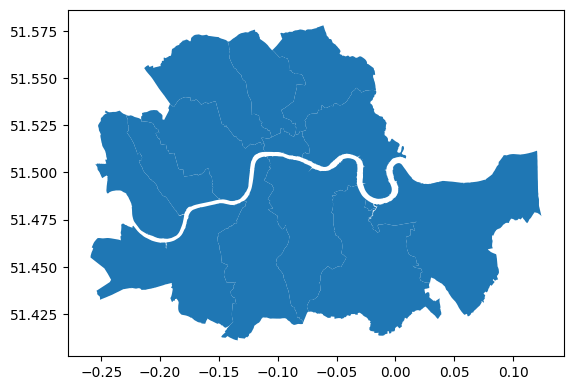

In [4]:
boroughs = gpd.read_file("https://darribas.org/gds_course/content/data/london_inner_boroughs.geojson")

boroughs.plot()

## K-means

Un análisis geodemográfico implica la clasificación de las áreas que componen un mapa geográfico en grupos o categorías de observaciones que son similares entre sí pero diferentes entre ellas. La clasificación se realiza utilizando un algoritmo de agrupamiento estadístico que toma como entrada un conjunto de atributos y devuelve el grupo ("etiquetas" en la terminología) al que pertenece cada observación. Dependiendo del algoritmo particular utilizado, también se necesitan ingresar parámetros adicionales, como el número deseado de grupos o parámetros de ajuste más avanzados (por ejemplo, ancho de banda, radio, etc.). Para nuestra clasificación geodemográfica de las calificaciones de AirBnb en Inner London, utilizaremos uno de los algoritmos de agrupamiento más populares: K-means. Esta técnica solo requiere como entrada los atributos de las observaciones y el número final de grupos en los que queremos agrupar las observaciones. En nuestro caso, comenzaremos con cinco, ya que esto nos permitirá analizar cada uno de ellos más de cerca.

K-means es probablemente el enfoque más ampliamente utilizado para agrupar un conjunto de datos. El algoritmo agrupa las observaciones en un número preespecificado de grupos para que cada observación esté más cerca de la media de su propio grupo que de la media de cualquier otro grupo. El problema de k-means se resuelve iterando entre un paso de asignación y un paso de actualización. Primero, todas las observaciones se asignan aleatoriamente a una de las k etiquetas. A continuación, se calcula la media multivariante de todos los covariables para cada uno de los grupos. Luego, cada observación se vuelve a asignar al grupo cuya media esté más cercana. Si la observación ya está asignada al grupo cuya media está más cercana, la observación permanece en ese grupo. Este proceso de asignación y actualización continúa hasta que no sea necesario realizar más reasignaciones.

La naturaleza de este algoritmo requiere que seleccionemos el número de grupos que queremos crear. El número correcto de grupos es desconocido en la práctica. A modo de ilustración, utilizaremos k=5 en la implementación de K-means de scikit-learn. Para proceder, primero creamos un agrupador de K-means. Aunque el algoritmo subyacente no es trivial, ejecutar K-means en Python es sencillo gracias a scikit-learn. Similar al extenso conjunto de algoritmos disponibles en la biblioteca, su computación es cuestión de dos líneas de código. Primero, necesitamos especificar los parámetros en el método K-means (que es parte del submódulo cluster de scikit-learn). Nótese que, en este punto, ni siquiera necesitamos pasar los datos:

In [5]:
kmeans5 = cluster.KMeans(n_clusters=5)
k5cls = kmeans5.fit(abb[variables]);

C:\Users\edier\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Esto configura un objeto que contiene todos los parámetros necesarios para ejecutar el algoritmo. En nuestro caso, solo pasamos el número de grupos (`n_clusters`) y el estado aleatorio, un número que garantiza que cada ejecución de K-means, que recuerde se basa en inicializaciones aleatorias, sea la misma y, por lo tanto, reproducible.

El objeto `k5cls` que acabamos de crear contiene varios componentes que pueden ser útiles para un análisis. Por ahora, utilizaremos las etiquetas, que representan las diferentes categorías en las que hemos agrupado los datos. Recuerda, en Python, la numeración comienza en cero, por lo que las etiquetas de grupo van de cero a cuatro. Las etiquetas se pueden extraer de la siguiente manera:


In [6]:
k5cls.labels_

array([0, 3, 0, 0, 1, 0, 0, 0, 0, 4, 3, 4, 4, 0, 0, 4, 3, 3, 0, 4, 3, 2,
       4, 2, 2, 4, 0, 4, 4, 1, 1, 1, 3, 1, 1, 1, 0, 3, 0, 3, 3, 1, 0, 1,
       4, 1, 4, 1, 0, 3, 3, 3, 0, 1, 1, 1, 0, 4, 1, 1, 1, 1, 3, 3, 1, 3,
       1, 3, 0, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 0, 0, 0, 4,
       0, 0, 3, 4, 0, 3, 4, 0, 4, 0, 2, 0, 2, 0, 0, 4, 0, 3, 0, 0, 0, 0,
       3, 3, 0, 0, 3, 3, 3, 0, 4, 3, 3, 3, 3, 0, 3, 0, 3, 0, 4, 0, 3, 4,
       0, 4, 4, 4, 0, 0, 0, 4, 4, 2, 3, 4, 3, 3, 3, 1, 3, 0, 3, 1, 0, 1,
       3, 3, 3, 2, 2, 2, 4, 2, 2, 0, 0, 0, 0, 4, 0, 3, 0, 3, 4, 0, 4, 0,
       4, 0, 0, 3, 4, 3, 1, 0, 1, 0, 3, 1, 1, 3, 0, 1, 0, 3, 3, 3, 3, 0,
       3, 3, 0, 0, 3, 3, 1, 0, 0, 4, 1, 1, 3, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       3, 1, 1, 3, 3, 4, 0, 1, 3, 4, 4, 2, 2, 4, 4, 0, 4, 4, 2, 4, 3, 4,
       4, 4, 4, 4, 0, 4, 0, 3, 0, 0, 3, 3, 0, 1, 1, 3, 3, 3, 1, 1, 0, 3,
       3, 0, 4, 0, 3, 4, 3, 4, 3, 0, 3, 4, 4, 4, 1, 0, 3, 4, 4, 1, 3, 4,
       4, 0, 3, 1, 3, 3, 4, 3, 2, 0, 3, 3, 3, 3, 3,

Cada número representa una categoría diferente, por lo que dos observaciones con el mismo número pertenecen al mismo grupo. Las etiquetas se devuelven en el mismo orden en que se pasaron los atributos de entrada, lo que significa que podemos agregarlas a la tabla original de datos como una columna adicional:

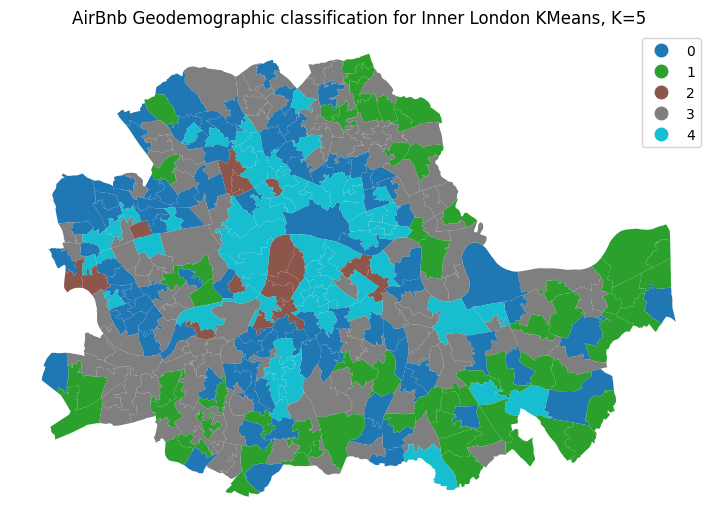

In [7]:
import matplotlib.pyplot as plt

abb['k5cls'] = k5cls.labels_

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('AirBnb Geodemographic classification for Inner London KMeans, K=5')
# Display the map
plt.show()

El mapa anterior representa la distribución geográfica de las cinco categorías creadas por el algoritmo K-means. Un vistazo rápido muestra una fuerte estructura espacial en la distribución de los colores: el grupo cero (azul) se encuentra principalmente en el centro de la ciudad y apenas en la periferia, mientras que el grupo uno (verde) está concentrado principalmente en el sur. El grupo cuatro (turquesa) es intermedio, mientras que el grupo dos (marrón) es mucho más pequeño, conteniendo solo unas pocas observaciones.

Una vez que tenemos una idea de dónde y cómo se distribuyen las categorías en el espacio, también es útil explorarlas estadísticamente. Esto nos permitirá caracterizarlas, dándonos una idea del tipo de observaciones que se incluyen en cada una de ellas. Como primer paso, veamos cuántas observaciones hay en cada categoría. Para hacerlo, haremos uso del operador `groupby` introducido anteriormente, combinado con la función `size`, que devuelve el número de elementos en un subgrupo:

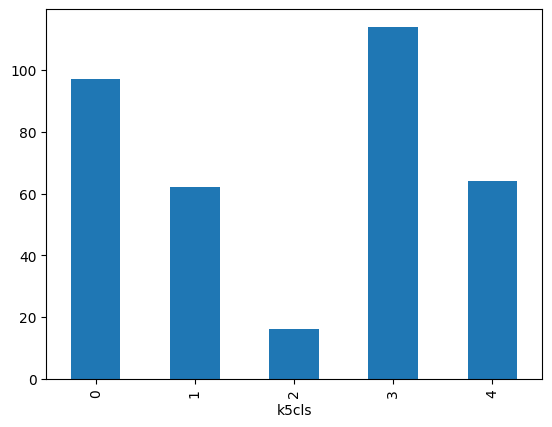

In [8]:
k5sizes = abb.groupby('k5cls').size()
_ = k5sizes.plot.bar()

Como sospechábamos por el mapa, los grupos tienen tamaños variables, con los grupos cero, tres y cuatro teniendo más de 75 observaciones cada uno, y uno y dos con menos de veinte.

Para describir la naturaleza de cada categoría, podemos examinar los valores de cada uno de los atributos que hemos utilizado para crearlas en primer lugar. Recuerde que utilizamos las calificaciones promedio en muchos aspectos (limpieza, comunicación del anfitrión, etc.) para crear la clasificación, así que podemos comenzar verificando el valor promedio de cada uno. Para hacerlo en Python, nos apoyaremos en el operador `groupby`, que combinaremos con la función `mean`:

In [9]:
# Calculate the mean by group
k5means = abb.groupby('k5cls')[variables].mean()
# Show the table transposed (so it's not too wide)
k5means.T

k5cls,0,1,2,3,4
bathrooms,1.300639,1.317806,1.279521,1.317698,1.260049
bedrooms,1.443016,1.471523,1.348264,1.479685,1.350441
beds,1.749863,1.761279,1.723329,1.748557,1.693512
number_of_reviews,17.948828,8.545149,35.208487,13.359278,23.686831


## Agrupamiento espacial (Regionalización)

En el contexto de preguntas explícitamente espaciales, un concepto relacionado, la región, también es fundamental. Una región es similar a un grupo, en el sentido de que todos los miembros de una región han sido agrupados juntos, y la región debería proporcionar un resumen de los datos originales. Además, para que una región sea analíticamente útil, sus miembros también deberían mostrar una mayor similitud entre sí que con los miembros de otras regiones. Sin embargo, las regiones son más complejas que los grupos porque combinan esta similitud en el perfil con información adicional sobre la geografía de sus miembros. En resumen, las regiones son como grupos (ya que tienen un perfil coherente), pero también tienen una geografía coherente: los miembros de una región también deberían estar ubicados cerca unos de otros.

El proceso de creación de regiones se llama **regionalización**. Una regionalización es un tipo especial de agrupación donde el objetivo es agrupar observaciones que son similares en sus atributos estadísticos, pero también en su ubicación espacial. En este sentido, la regionalización incorpora la misma lógica que las técnicas de agrupación estándar, pero también aplica una serie de restricciones espaciales y/o geográficas. A menudo, estas restricciones se relacionan con la conectividad: dos candidatos solo pueden agruparse juntos en la misma región si existe un camino de un miembro a otro que nunca abandona la región. Estos caminos a menudo modelan las relaciones espaciales en los datos, como la contigüidad o la proximidad. Sin embargo, la conectividad no siempre necesita mantenerse para todas las regiones, y en ciertos contextos tiene sentido relajar la conectividad o imponer diferentes tipos de restricciones espaciales.

En el caso del análisis de datos espaciales, hay un subconjunto de métodos que son de particular interés para muchos casos comunes en la Ciencia de Datos Geográficos. Estos son los llamados métodos de *regionalización*. Los métodos de regionalización pueden tomar muchas formas y caras, pero, en su núcleo, todos implican la agrupación estadística de observaciones con la restricción adicional de que las observaciones deben ser vecinas geográficas para estar en la misma categoría. Debido a esto, en lugar de categoría, usaremos el término *área* para cada observación y *región* para cada categoría, de ahí la regionalización, la construcción de regiones a partir de áreas más pequeñas.

La regionalización es el subconjunto de técnicas de agrupación que imponen una restricción espacial en la clasificación. En otras palabras, el resultado de un algoritmo de regionalización contiene áreas que son contiguas espacialmente. En efecto, lo que esto significa es que estas técnicas agregan áreas en un conjunto más pequeño de áreas más grandes, llamadas regiones. En este contexto, entonces, las áreas están *anidadas* dentro de las regiones. Ejemplos del mundo real de este fenómeno incluyen condados dentro de estados o, en el Reino Unido, áreas de salida supermediana local (LSOA) en áreas de salida supermediana media (MSOA). La diferencia entre esos ejemplos y el resultado de un algoritmo de regionalización es que, mientras que los primeros se agregan en función de principios administrativos, el último sigue una técnica estadística que, de la misma manera que en la agrupación estadística estándar, agrupa áreas que son similares en función de un conjunto de atributos. Solo que ahora, dicha agrupación estadística está espacialmente restringida.

Al igual que en el caso no espacial, hay muchos algoritmos diferentes para realizar la regionalización, y todos difieren en detalles relacionados con la forma en que miden la (des) similitud, el proceso para regionalizar, etc. Sin embargo, al igual que arriba también, todos comparten algunos aspectos comunes. En particular, todos toman un conjunto de atributos de entrada *y* una representación del espacio en forma de una matriz binaria de pesos espaciales. Dependiendo del algoritmo, también requieren el número deseado de regiones de salida en las cuales se agregan las áreas.

Para ilustrar estos conceptos, ejecutaremos un algoritmo de regionalización en los datos de AirBnb que hemos estado utilizando. En este caso, el objetivo será volver a delinear las líneas de límite de los distritos del Londres Interior siguiendo una lógica basada en las diferentes calificaciones promedio en las propiedades de AirBnb, en lugar de las razones administrativas detrás de las líneas de límite existentes. De esta manera, las regiones resultantes representarán un conjunto coherente de áreas que son similares entre sí en términos de las calificaciones recibidas.

Para este ejemplo, utilizaremos una versión espacialmente restringida del algoritmo aglomerativo. Este es un enfoque similar al utilizado anteriormente (sin embargo, los detalles internos del algoritmo son diferentes) con la diferencia de que, en este caso, las observaciones solo pueden etiquetarse en el mismo grupo si son vecinos espaciales, según lo define nuestra matriz de pesos espaciales `w`. La forma de interactuar con el algoritmo es muy similar a la anterior.

La agrupación aglomerativa funciona construyendo una jerarquía de soluciones de agrupación que comienza con todos los individuos (cada observación es un único grupo en sí mismo) y termina con todas las observaciones asignadas al mismo grupo. Estos extremos no son muy útiles en sí mismos. Pero, en el medio, la jerarquía contiene muchas soluciones de agrupación distintas con diferentes niveles de detalle. La intuición detrás del algoritmo también es bastante sencilla:

1. comenzar con todos como parte de su propio grupo;

2. encontrar las dos observaciones más cercanas basadas en una métrica de distancia (por ejemplo, euclidiana);

3. unirlas en un nuevo grupo;

4. repetir los pasos 2) y 3) hasta alcanzar el grado de agregación deseado.

El algoritmo se llama "aglomerativo" porque comienza con grupos individuales y "aglomera" en grupos cada vez menos que contienen cada vez más observaciones. Además, al igual que con k-means, AHC requiere que el usuario especifique un número de grupos de antemano. Esto se debe a que, siguiendo el mecanismo que el método tiene para construir grupos, AHC puede proporcionar una solución con tantos grupos como observaciones (k=n), o con solo uno (k=1).

Para este caso utilizaremos la matriz de contingencia tipo **Queen**.

In [10]:
w = Queen.from_dataframe(abb)
w.islands

C:\Users\edier\AppData\Local\Temp\ipykernel_38876\3545412587.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(abb)


[]

Como hemos visto antes, w no contiene ninguna isla:

In [11]:
sagg13 = cluster.AgglomerativeClustering(n_clusters=13, connectivity=w.sparse)
sagg13cls = sagg13.fit(abb[variables])

Y luego añadimos las etiquetas a la tabla:

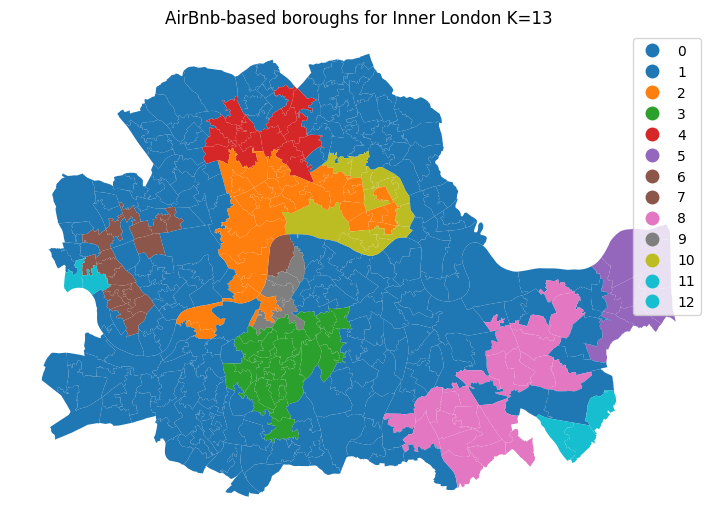

In [12]:
abb['sagg13cls'] = sagg13cls.labels_

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(column='sagg13cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('AirBnb-based boroughs for Inner London K=13')
# Display the map
plt.show()

La restricción espacial en los algoritmos de regionalización está estructurada por la matriz de pesos espaciales que utilizamos. Una pregunta interesante es cómo influye la elección de los pesos en la estructura final de las regiones. Afortunadamente, podemos explorar directamente el impacto que un cambio en la matriz de pesos espaciales tiene en la regionalización. Para hacerlo, utilizamos los mismos datos de atributos pero reemplazamos la matriz de contigüidad Queen con una matriz espacial de vecinos más cercanos k, donde cada observación está conectada a sus cuatro observaciones más cercanas, en lugar de aquellas que toca.

In [13]:
w = KNN.from_dataframe(abb, k=4)

Con esta matriz que conecta cada área con las cuatro áreas más cercanas, podemos ejecutar otra regionalización de AHC:


In [14]:
np.random.seed(123456)
model = AgglomerativeClustering(linkage='ward',connectivity=w.sparse,n_clusters=5)
model.fit(abb[variables])

AgglomerativeClustering(connectivity=<353x353 sparse matrix of type '<class 'numpy.float64'>'
	with 1412 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

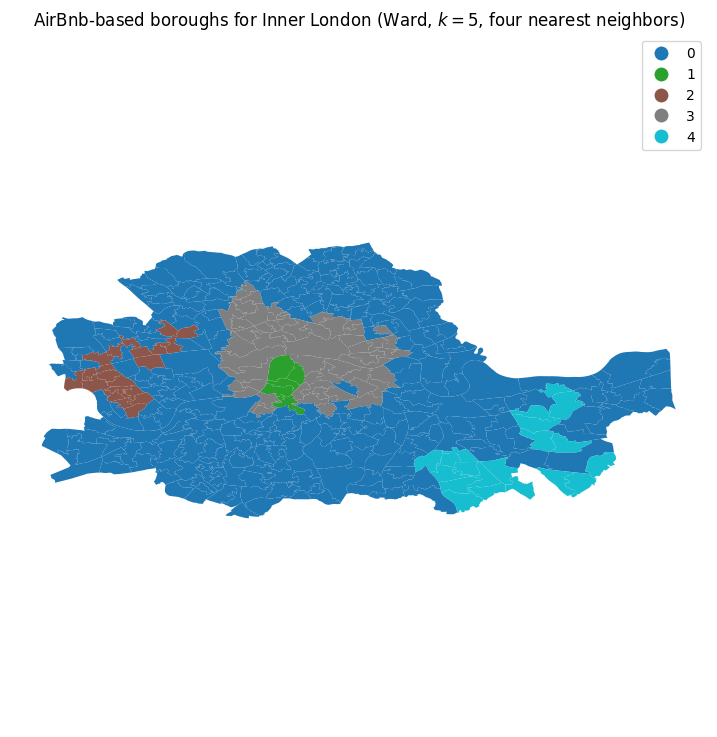

In [15]:
abb['ward5wknn'] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
abb.plot(column='ward5wknn', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('AirBnb-based boroughs for Inner London (Ward, $k=5$, four nearest neighbors)')
# Display the map
plt.show()

Aunque hemos especificado una restricción espacial, la restricción se aplica al gráfico de conectividad modelado por nuestra matriz de pesos. Por lo tanto, el uso de los k-vecinos más cercanos para limitar el agrupamiento aglomerativo puede no dar como resultado regiones que estén conectadas según una regla de conectividad diferente, como la regla de contigüidad de reina utilizada en la sección anterior. Sin embargo, la regionalización aquí es fortuita; aunque usamos los 4 vecinos más cercanos para limitar la conectividad, todos menos uno de los grupos, el grupo 4, también están conectados según nuestra regla de contigüidad de reina anterior.

A primera vista, esto puede parecer contradictorio. Especificamos la restricción espacial, por lo que nuestra reacción inicial es que la restricción de conectividad se viola. Sin embargo, este no es el caso, ya que la restricción se aplica al gráfico de k-vecinos más cercanos, no al gráfico de contigüidad de reina. Por lo tanto, dado que los sectores en esta solución se consideran conectados a sus cuatro vecinos más cercanos, los grupos pueden "saltar" sobre otros. Por lo tanto, es importante reconocer que la estructura espacial aparente de las regionalizaciones dependerá de cómo se modele la conectividad de las observacione.